In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd

df = pd.read_json('/kaggle/input/audio-files/1188976.json')

In [1]:
import os
import pandas as pd


emotions = {
    1: 'calm', 2: 'happy', 3: 'sad',
    4: 'angry', 5: 'fearful', 6: 'disgust'
}

In [2]:
def extract_data_from_name(fname):
    parts = fname.split('.')[0].split('-')
    return {
        'filename': fname,
        'modality': int(parts[0]),
        'channel': int(parts[1]),  # 1 = speech, 2 = song
        'emotion_id': int(parts[2]),
        'emotion': emotions.get(int(parts[2]), 'unknown'),
        'intensity': int(parts[3]),
        'statement': int(parts[4]),
        'repeat': int(parts[5]),
        'actor': int(parts[6]),
        'gender': 'male' if int(parts[6]) % 2 != 0 else 'female'
    }

In [3]:
def create_dataframe(link):
    data = []
    for root, dirs, files in os.walk(link):
        for file in files:
            if file.endswith(".wav"):
                metadata = extract_data_from_name(file)
                metadata['path'] = os.path.join(root, file)
                data.append(metadata)
    return pd.DataFrame(data)


dataset_path = "/kaggle/input/training-audio-data/Training_data"
df = create_dataframe(dataset_path)


In [4]:
df.shape

(2452, 11)

In [5]:
df.sample(5)

,filename,modality,channel,emotion_id,emotion,intensity,statement,repeat,actor,gender,path
904,03-02-03-02-02-01-03.wav,3,2,3,sad,2,2,1,3,male,/kaggle/input/training-audio-data/Training_dat...
243,03-02-02-01-01-02-01.wav,3,2,2,happy,1,1,2,1,male,/kaggle/input/training-audio-data/Training_dat...
1391,03-01-05-01-01-01-11.wav,3,1,5,fearful,1,1,1,11,male,/kaggle/input/training-audio-data/Training_dat...
2097,03-01-04-01-01-01-09.wav,3,1,4,angry,1,1,1,9,male,/kaggle/input/training-audio-data/Training_dat...
1737,03-01-03-02-02-01-23.wav,3,1,3,sad,2,2,1,23,male,/kaggle/input/training-audio-data/Training_dat...


In [6]:
df.isnull().sum()

filename      0
modality      0
channel       0
emotion_id    0
emotion       0
intensity     0
statement     0
repeat        0
actor         0
gender        0
path          0
dtype: int64

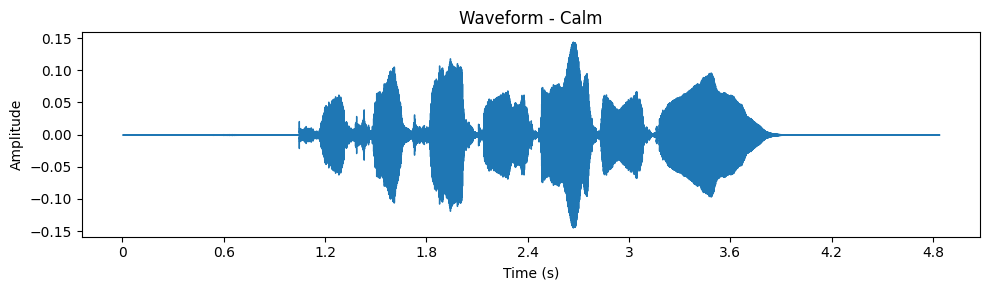

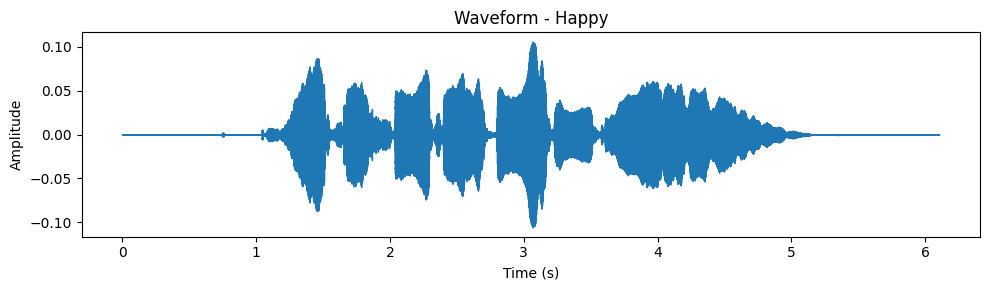

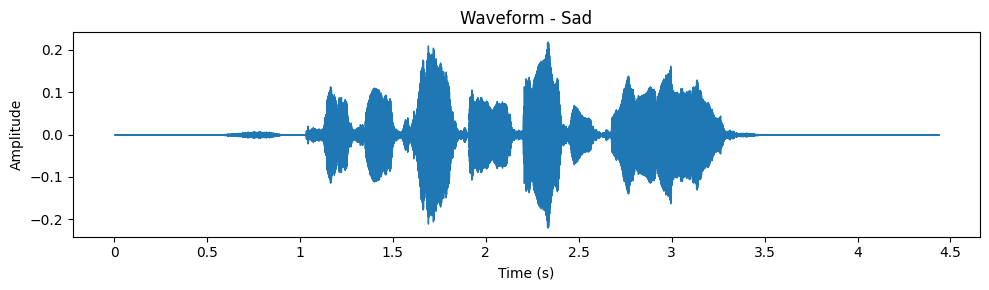

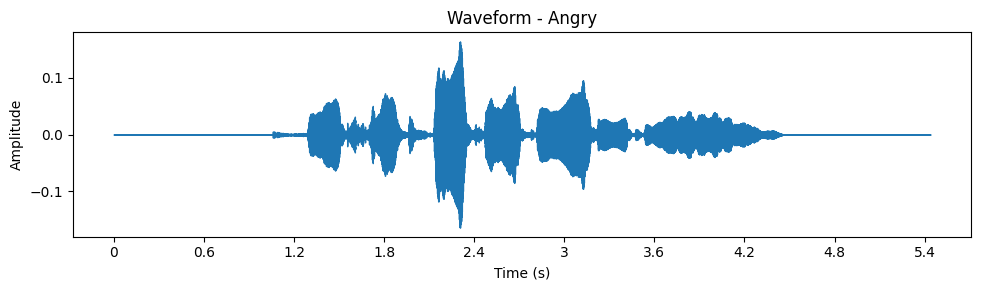

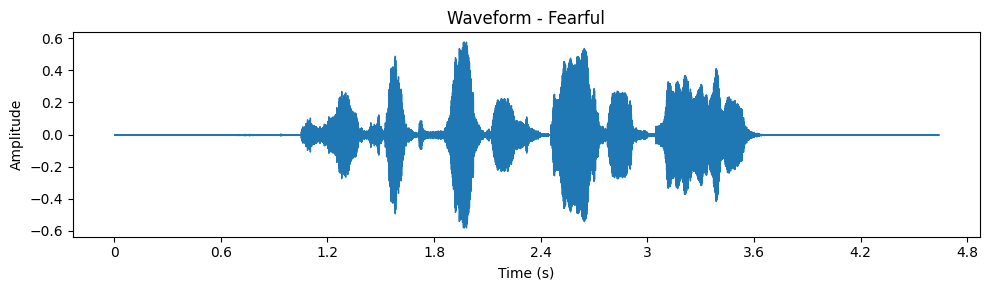

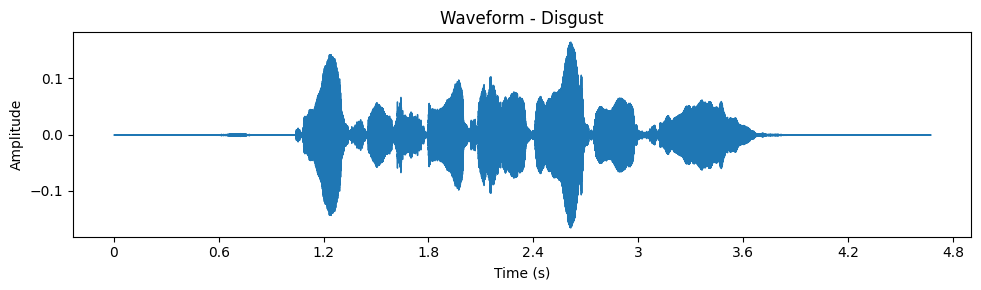

In [9]:
import librosa
import matplotlib.pyplot as plt 

for emotion in emotions.values():
    emotion_df = df[df['emotion'] == emotion]

    if not emotion_df.empty:
            row = emotion_df.iloc[0]  
            y, sr = librosa.load(row['path'], sr=None)

            plt.figure(figsize=(10, 3))
            librosa.display.waveshow(y, sr=sr)
            plt.title(f'Waveform - {emotion.capitalize()}')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.tight_layout()
            plt.show()


In [10]:
df[['filename', 'emotion', 'path']].head()

,filename,emotion,path
0,03-02-05-02-01-01-02.wav,fearful,/kaggle/input/training-audio-data/Training_dat...
1,03-02-06-01-02-02-02.wav,disgust,/kaggle/input/training-audio-data/Training_dat...
2,03-02-03-02-01-02-02.wav,sad,/kaggle/input/training-audio-data/Training_dat...
3,03-02-03-01-02-02-02.wav,sad,/kaggle/input/training-audio-data/Training_dat...
4,03-02-04-02-01-01-02.wav,angry,/kaggle/input/training-audio-data/Training_dat...


In [11]:
import librosa
import numpy as np

#Applying mfcc - audio waveforn --> fourier transform --> mel scaling --> logarithm --> inverse fourier transform(Cepstrum, Quefrency) 
def extract_mfcc_features(wav_path, n_mfcc=40):
        y, sr = librosa.load(wav_path, sr=None)  
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc) 
        mfcc_mean = np.mean(mfcc.T, axis=0) 
        return mfcc_mean


In [12]:
df['mfcc'] = df['path'].apply(extract_mfcc_features)


In [19]:
import numpy as np
X = np.stack(df['mfcc'].values)

In [20]:
X.shape

(2452, 40)

In [13]:
print(df[['emotion', 'mfcc']].sample(35))


      emotion                                               mfcc
162      calm  [-611.414, 52.077103, -7.7668667, 7.9935927, -...
1450     calm  [-730.7835, 56.75626, -12.5367365, 10.968933, ...
1917  disgust  [-454.50644, 32.319195, -18.824198, -0.799793,...
992   fearful  [-548.1975, 73.75191, -5.673457, 15.314538, 7....
227     angry  [-550.9572, 83.02543, -16.116215, 9.233311, 1....
909   disgust  [-378.7503, 104.495094, -21.185535, 11.80531, ...
1801      sad  [-679.4288, 66.72483, -13.251517, 3.398292, -2...
2044  unknown  [-520.56665, 57.123196, -0.47767264, 6.28597, ...
2125    happy  [-792.878, 84.40293, 11.711248, 22.659185, 10....
317     angry  [-668.22363, 62.96976, -28.053658, 5.7660995, ...
2167  unknown  [-697.80884, 48.78155, -3.7000659, 3.683173, -...
1784  fearful  [-565.2382, 57.86759, -9.377352, 5.6245866, -1...
1231  unknown  [-634.4156, 60.700737, -4.7377057, 2.8596606, ...
953     happy  [-653.0686, 104.73632, -9.213408, 13.644442, 5...
505       sad  [-480.3472

In [14]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = df['emotion'].values
y_encoded = le.fit_transform(y)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [26]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',   
    n_estimators = 400,
    max_depth = 6,
    learning_rate = 0.07,
    subsample = 0.8,
    reg_alpha = 0.5,
    reg_lambda = 1,
    num_class=6,     
    eval_metric='mlogloss',         
    use_label_encoder=False,        
    random_state=42
)

In [27]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

y_test1 = le.inverse_transform(y_test)
y_pred1 = le.inverse_transform(y_pred)


Accuracy: 0.7881873727087576

Classification Report:
               precision    recall  f1-score   support

       angry       0.81      0.62      0.70        80
        calm       0.90      0.73      0.81        37
     disgust       0.75      0.78      0.77        74
     fearful       0.83      0.87      0.85        67
       happy       0.74      0.94      0.83        65
         sad       0.86      0.75      0.80        79
     unknown       0.73      0.83      0.78        89

    accuracy                           0.79       491
   macro avg       0.80      0.79      0.79       491
weighted avg       0.79      0.79      0.79       491



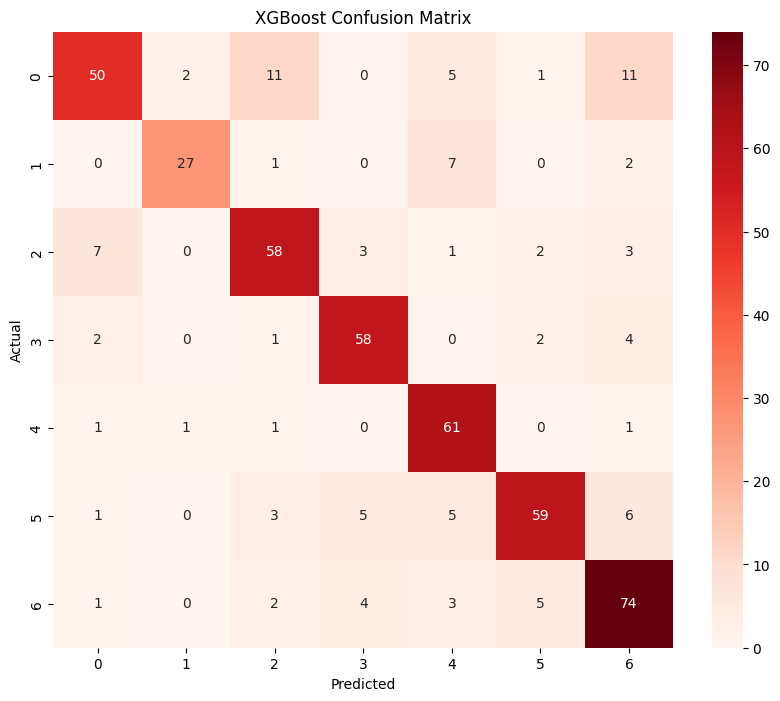

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(y_test1, y_pred1))


print("\nClassification Report:\n", classification_report(y_test1, y_pred1))

cm = confusion_matrix(y_test1, y_pred1)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Reds",)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [29]:
import pickle


with open("model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)


with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)